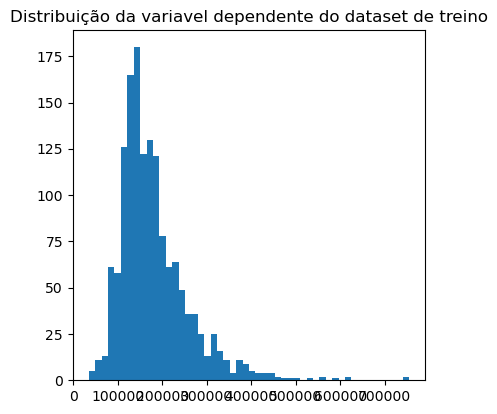

Id
1    208500
2    181500
3    223500
4    140000
5    250000
Name: SalePrice, dtype: int64


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
X_full = pd.read_csv('D:/DataScience/house_price_competitions_kaggle/train.csv', index_col='Id')

# Separate target from predictors
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Checking the distribution of y
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221)
plt.hist(y, bins = 50)
ax.set_title("Distribuição da variavel dependente do dataset de treino")
plt.show()

print(y.head())

lambda do box-cox: -0.07692391328663316


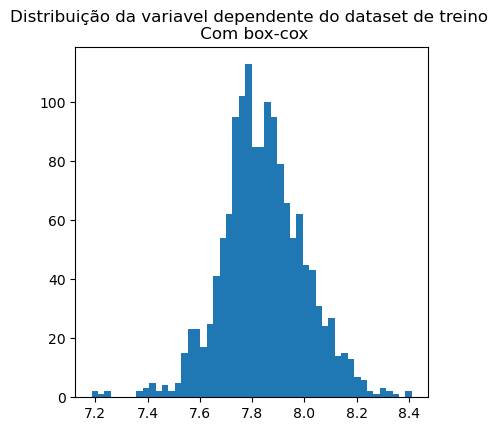

[7.93261046 7.87826333 7.95961804 ... 8.02738182 7.78100579 7.79588702]


In [2]:
from scipy import stats

# Transforming the variable y with box-cox to normalize it
bc_y = stats.boxcox(y)

y = bc_y[0]

print('lambda do box-cox:', bc_y[1])

# Re-checking the distribution of y w/ box-cox
fig1 = plt.figure(figsize=(10,10))

ax = fig1.add_subplot(221)
plt.hist(y, bins = 50)
ax.set_title("Distribuição da variavel dependente do dataset de treino \n Com box-cox")
plt.show()

print(bc_y[0])

In [4]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 20 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(random_state=0)

# Bundle preprocessing and modeling code in a pipeline
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Defining Grid params
grid_params = {'model__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500]}

# Define the GridSearchCV
grid_search = GridSearchCV(pipe_rf, grid_params, cv=5).fit(X_train, y_train)

rf_model = grid_search.best_estimator_

# get predictions
preds = rf_model.predict(X_valid)
MAE = mean_absolute_error(y_valid, preds)
RMSE = mean_squared_error(y_valid, preds)**(1/2)
R2 = r2_score(y_valid, preds)

print('MAE:', MAE)
print('RMSE:', RMSE)
print('R-quadrado:', R2)

MAE: 0.0363669032882267
RMSE: 0.05450444288009135
R-quadrado: 0.8733954702053652


In [6]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# XGB model 
model_1 = XGBRegressor()

# Bundle preprocessing and modeling code in a pipeline
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model_1', model_1)])

# Defining Grid params
grid_params_xgb = {'model_1__n_estimators': [500, 600, 700, 800, 900, 1000],
                   'model_1__learning_rate': [0.01, 0.05],
                   'model_1__max_depth': [4, 5, 6]}

# Define the GridSearchCV
grid_search_xgb = GridSearchCV(pipe_xgb, grid_params_xgb, cv=3).fit(X_train, y_train)

xgb_model = grid_search_xgb.best_estimator_

# Preprocessing of validation data, get predictions
preds_xgb = xgb_model.predict(X_valid)
MAE = mean_absolute_error(y_valid, preds_xgb)
RMSE = mean_squared_error(y_valid, preds_xgb)**(1/2)
R2 = r2_score(y_valid, preds_xgb)

print('MAE:', MAE)
print('RMSE:', RMSE)
print('R-quadrado:', R2)

C:\Users\mathe\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


MAE: 0.03382475143187525
RMSE: 0.049738789229949655
R-quadrado: 0.8945671725525257


In [7]:
# Read the test data
X_test_full = pd.read_csv('D:/DataScience/house_price_competitions_kaggle/test.csv', index_col='Id')

X_test = X_test_full[my_cols].copy()

# Using the model with higher R2 'xgb_model'
preds_test = xgb_model.predict(X_test)

# Defining a function to get the real values from box-cox transformation
def real_values(p, lmbda):
    r = (((p * lmbda)+1)**(1/(lmbda)))
    return r

# Getting the values without box-cox transformation
values_preds = real_values(preds_test, bc_y[1])

print(values_preds)

[122870.945 161926.17  190529.84  ... 167288.8   109624.64  225120.97 ]


In [8]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': values_preds})
output.to_csv('submission.csv', index=False)